Epoch [1/20], Loss: 273.7654
Epoch [2/20], Loss: 251.7401
Epoch [3/20], Loss: 247.4788
Epoch [4/20], Loss: 245.4688
Epoch [5/20], Loss: 244.2758
Epoch [6/20], Loss: 243.4456
Epoch [7/20], Loss: 242.8178
Epoch [8/20], Loss: 242.2905
Epoch [9/20], Loss: 241.9432
Epoch [10/20], Loss: 241.6308
Epoch [11/20], Loss: 241.3152
Epoch [12/20], Loss: 241.0640
Epoch [13/20], Loss: 240.8864
Epoch [14/20], Loss: 240.6495
Epoch [15/20], Loss: 240.5009
Epoch [16/20], Loss: 240.3564
Epoch [17/20], Loss: 240.1970
Epoch [18/20], Loss: 240.0998
Epoch [19/20], Loss: 240.0079
Epoch [20/20], Loss: 239.8832


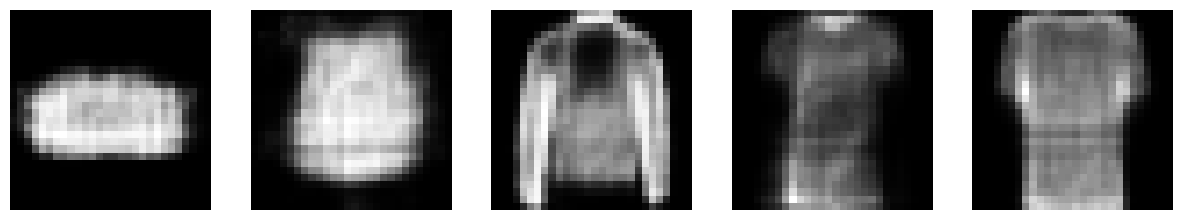

In [1]:
import torch
import torch.nn as nn
import torch.optim as optim
from torchvision import datasets, transforms
from torch.utils.data import DataLoader
import matplotlib.pyplot as plt

# 1. Hyperparameters
BATCH_SIZE = 64
LEARNING_RATE = 1e-3
EPOCHS = 20
LATENT_DIM = 20  # Latent space dimension
IMAGE_SIZE = 28  # Fashion MNIST image size (28x28)
INPUT_DIM = IMAGE_SIZE * IMAGE_SIZE  # Flattened image dimension
HIDDEN_DIM = 400  # Hidden layer dimension

# 2. Prepare Fashion MNIST Dataset
transform = transforms.Compose([transforms.ToTensor()])
train_dataset = datasets.FashionMNIST(root='./data', train=True, transform=transform, download=True)
train_loader = DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True)

# 3. Define the VAE model
class VAE(nn.Module):
    def __init__(self):
        super(VAE, self).__init__()
        # Encoder
        self.fc1 = nn.Linear(INPUT_DIM, HIDDEN_DIM)  # First fully connected layer
        self.fc_mu = nn.Linear(HIDDEN_DIM, LATENT_DIM)  # Mean for the latent variable
        self.fc_logvar = nn.Linear(HIDDEN_DIM, LATENT_DIM)  # Log variance for the latent variable
        
        # Decoder
        self.fc2 = nn.Linear(LATENT_DIM, HIDDEN_DIM)  # Fully connected layer in decoder
        self.fc3 = nn.Linear(HIDDEN_DIM, INPUT_DIM)  # Output layer (reconstructs the image)
        
    def encode(self, x):
        h1 = torch.relu(self.fc1(x))
        mu = self.fc_mu(h1)
        logvar = self.fc_logvar(h1)
        return mu, logvar
    
    def reparameterize(self, mu, logvar):
        std = torch.exp(0.5 * logvar)  # Compute standard deviation
        eps = torch.randn_like(std)  # Sample epsilon from N(0, 1)
        return mu + eps * std  # Reparameterization trick
    
    def decode(self, z):
        h2 = torch.relu(self.fc2(z))
        return torch.sigmoid(self.fc3(h2))  # Sigmoid to ensure the output is between 0 and 1
    
    def forward(self, x):
        mu, logvar = self.encode(x.view(-1, INPUT_DIM))  # Encode the input
        z = self.reparameterize(mu, logvar)  # Reparameterization step
        return self.decode(z), mu, logvar  # Decode the latent variable and return

# 4. Loss Function (VAE Loss: Reconstruction + KL Divergence)
def vae_loss(recon_x, x, mu, logvar):
    BCE = nn.functional.binary_cross_entropy(recon_x, x.view(-1, INPUT_DIM), reduction='sum')  # Reconstruction loss
    # KL Divergence
    KLD = -0.5 * torch.sum(1 + logvar - mu.pow(2) - logvar.exp())
    return BCE + KLD

# Initialize model, optimizer
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model = VAE().to(device)
optimizer = optim.Adam(model.parameters(), lr=LEARNING_RATE)

# 5. Training the VAE
for epoch in range(EPOCHS):
    model.train()
    train_loss = 0
    for batch_idx, (data, _) in enumerate(train_loader):
        data = data.to(device)
        optimizer.zero_grad()
        recon_batch, mu, logvar = model(data)
        loss = vae_loss(recon_batch, data, mu, logvar)
        loss.backward()
        train_loss += loss.item()
        optimizer.step()
    
    avg_loss = train_loss / len(train_loader.dataset)
    print(f'Epoch [{epoch+1}/{EPOCHS}], Loss: {avg_loss:.4f}')

# 6. Generating New Images from VAE
def generate_images(model, num_images):
    model.eval()
    with torch.no_grad():
        z = torch.randn(num_images, LATENT_DIM).to(device)  # Sample random latent variables
        samples = model.decode(z).cpu()
        return samples.view(num_images, 1, IMAGE_SIZE, IMAGE_SIZE)

# Generate and visualize new images
num_images = 5
generated_images = generate_images(model, num_images)

# Plot the generated images
fig, axes = plt.subplots(1, num_images, figsize=(15, 5))
for i, img in enumerate(generated_images):
    axes[i].imshow(img.squeeze(), cmap='gray')
    axes[i].axis('off')
plt.show()
